# Введение

Структура скрипта:

1. Импорт библиотек и настройка среды выполнения.
2. Загрузка исторических данных о котировках акций.
3. Сравнение кумулятивной доходности акций.
4. Оптимизация портфеля акций.

# Импорт библиотек и настройка среды выполнения

In [360]:
import datetime as dt # для работы с датами
import matplotlib.pyplot as plt # для посроения графиков
from matplotlib import style # для настройки стиля графиков
import pandas as pd # для создания датафреймов
import pandas_datareader.data as web # для загрузки данных из веба
from dateutil.relativedelta import relativedelta # для математических вычислений с датами

In [361]:
style.use('ggplot') # установка стиля графиков

start = dt.datetime(2019, 1, 1) # самая ранняя дата периода, за который будем загружать информацию
today = dt.datetime.now() # самая поздняя дата периода, за который будем загружать информацию, т.е. сегодня

# Загрузка исторических данных о котировках ценных бумаг

В рамках данного исследования будут рассматриваться котировки акций нескольких компаний:
* Microsoft (тикер MSFT)
* Apple (тикер AAPL)
* Visa (тикер V)
* Intel (тикер INTC)
* Activision Blizzard (тикер ATVI)
* М.Видео (тикер MVID)
* Сбербанк - привилегированные (тикер SBERP) 

Данные компании были отобраны по следующим прицницам: 
* Представляют технологическую и финансовые отрасли, имеющие хорошую динамику развития
* Демонстрируют стремление к постоянному развитию своих продуктов
* Не показывали убыток за последние несколько лет
* Стабильно выплачивают дивидены

In [362]:
# Определим список тикеров. Нам также нужно загрузить курсы доллара к рублю для конвертации рублевых тикеров в доллары. Тикеры, торгуемые на Московской бирже, имеют окончание .ME
tickers = ['USDRUB=X', 'MSFT', 'AAPL', 'V', 'INTC', 'ATVI', 'MVID.ME', 'SBERP.ME']

In [363]:
# создадим пустой датафрейм, в котором каждый столбец соответсвует каждому тикеру из списка
stock_data = pd.DataFrame(columns=tickers)

Для загрузки данных будем использовать библиотеку pandas_datareader. Она может использовать различные источники данных, но в данном скрипте будет использоватья Yahoo Finance. Компании, торгуемые на Московской бирже, имеют окончание .ME. Период, за который будут загружаться данные о котировках: с 1 января 2019 года по текущий день. Для анализа будет использоваться скорректированная цена закрытия на конец дня (цена закрытия, скорректированная на дивиденды и сплиты). Точность временных данных в один день недостаточна для алгоритмической торговли, но достаточна для целей данного исследования: фундаментальной балансировки портфеля.

In [364]:
for ticker in tickers:
    stock_data[ticker] = web.DataReader(ticker, 'yahoo', start, today)['Adj Close']

Для тикеров, номинированных в рублях, необходимо сконвертировать стоимость из рублей в доллары. После этого информацию о курсе доллара к рублю можно отбросить.

In [365]:
moex_tickers = [ticker for ticker in tickers if '.ME' in ticker]
for moex_ticker in moex_tickers:
    stock_data[moex_ticker] = stock_data.apply(lambda row: row[moex_ticker] / row['USDRUB=X'], axis=1) # курс российских акций в долларах = курс акций в рублях / курс доллара к рублю

In [366]:
stock_data.drop(columns='USDRUB=X', inplace=True) # удалим курс доллара к рублю
stock_data.columns = stock_data.columns.str.rstrip('.ME') # удалим окончание .ME для российских тикеров

В рамках данной задачи будем рассматривать годовую доходность.

In [367]:
one_year_ago = today - relativedelta(years=1)
last_year_stock_data = stock_data[stock_data.index >= one_year_ago]

Нас интересует не сравнение курсов акций в абсолютном выражении и не изучение истории колебаний курсов, а относительный возврат на инвестиции - выраженный как нарастающий итог изменения доходности.

In [368]:
one_year_cumulative_return = (last_year_stock_data.pct_change() + 1).cumprod()

Отобразим итог по кумулятивной доходности акций, актуальный по состоянию на сегодня, в графическом и матричном виде.

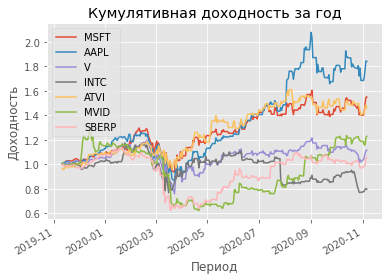

In [369]:
one_year_cumulative_return.plot()
plt.title("Кумулятивная доходность за год")
plt.legend()
plt.ylabel('Доходность')
plt.xlabel('Период')
plt.show()

In [370]:
one_year_cumulative_total_return = one_year_cumulative_return.tail(1).transpose()
one_year_cumulative_total_return.sort_values(by=one_year_cumulative_total_return.columns[0], ascending=False, inplace=True)
one_year_cumulative_total_return = one_year_cumulative_total_return.apply(lambda row:"{:.2%}".format(row[0] - 1),  axis=1)
print(f'Возврат на инвестиции за последний год:\n{one_year_cumulative_total_return.to_string()}')

Возврат на инвестиции за последний год:
AAPL      84.08%
MSFT      55.02%
ATVI      46.09%
MVID      22.97%
V         11.60%
SBERP      5.52%
INTC     -20.17%
